# Support Vector Machines (SVM) - Primal and Dual Formulation

This notebook implements both the primal and dual formulations of the Support Vector Machine algorithm. 

**Part 1: Primal SVM with a Linear Kernel**
- Solves the primal optimization problem using `cvxopt`.
- Uses 5-fold cross-validation to select the optimal hyperparameter `C`.
- Visualizes the final decision boundary, margins, and support vectors.

**Part 2: Dual SVM with a Non-linear (RBF) Kernel**
- Implements the Gaussian (RBF) kernel.
- Solves the dual optimization problem using `cvxopt` to find the alpha coefficients.
- Uses 5-fold cross-validation to select the optimal hyperparameter `C`.
- Visualizes the non-linear decision boundary and support vectors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from cvxopt import matrix, solvers
from sklearn.metrics import confusion_matrix, accuracy_score

# Testing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


## 1. Data Loading and Preparation

In [2]:
# Load data from the CSV file
data = np.loadtxt("./data_svm.csv", delimiter=',')

# Shuffle the data for randomness in cross-validation folds. A seed is used for reproducibility.
np.random.seed(42)
np.random.shuffle(data)

# m = number of examples, n = number of features
m, n = data.shape
n -= 1  # Adjust for the label column

# Separate features (X) and labels (y)
X = data[:, 0:2]
y = data[:, 2]
y = y.reshape((m, 1)) # Reshape y to be a column vector

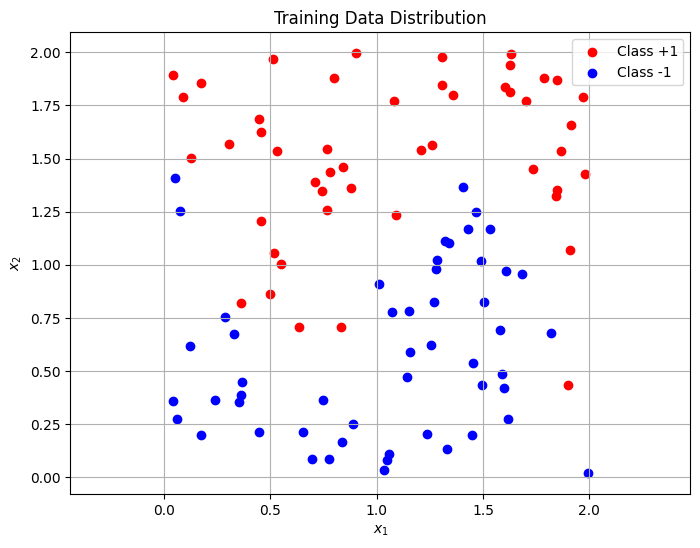

In [3]:
# Plotting the initial training data
plt.figure(figsize=(8, 6))
# For this plot, we assume the data has been processed or will be handled accordingly.
plt.scatter(X[(y == 1).flatten(), 0], X[(y == 1).flatten(), 1], c='red', label='Class +1')
plt.scatter(X[(y == -1).flatten(), 0], X[(y == -1).flatten(), 1], c='blue', label='Class -1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("Training Data Distribution")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

## Part 1: Primal SVM with Linear Kernel

We solve the primal optimization problem:
$$ \min_{w, b, \xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{m} \xi_i $$
subject to:
$$ y^{(i)}(w^T x^{(i)} + b) \ge 1 - \xi_i, \quad \xi_i \ge 0, \quad i=1, \dots, m $$

In [4]:
def train_svm_primal(X_train, y_train, C):
    """
    Trains a linear soft-margin SVM using the primal formulation.
    The problem is solved as a quadratic program (QP) using cvxopt.

    Args:
        X_train (np.ndarray): Training features, shape (m, n).
        y_train (np.ndarray): Training labels, shape (m, 1), values in {-1, 1}.
        C (float): Regularization (penalty) parameter.
        
    Returns:
        w (np.ndarray): The learned weight vector, shape (n, 1).
        b (float): The learned bias term.
        xi (np.ndarray): The slack variables, shape (m, 1).
    """
    m, n = X_train.shape

    # --- QP Formulation for cvxopt: min 1/2 * x'Px + q'x, subject to Gx <= h, Ax = b ---
    # Our optimization variable vector is x = [w, b, xi], with total length (n + 1 + m).

    # 1. Define the quadratic term matrix P for the objective function (1/2 * w'w)
    # P is a block matrix with the identity matrix for the w part and zeros elsewhere.
    P = np.zeros((n + 1 + m, n + 1 + m))
    P[:n, :n] = np.eye(n)

    # 2. Define the linear term vector q for the objective function (C * sum(xi))
    # q has zeros for w and b, and C for all slack variables xi.
    q = np.vstack([
        np.zeros((n + 1, 1)),
        C * np.ones((m, 1))
    ])

    # 3. Define the inequality constraint matrix G and vector h
    # Constraint 1: y_i(w'x_i + b) >= 1 - xi  =>  -y_i(w'x_i + b) - xi <= -1
    G_margin = np.hstack([
        -y_train * X_train, # Coefficients for w
        -y_train,           # Coefficients for b
        -np.eye(m)          # Coefficients for xi
    ])

    # Constraint 2: xi >= 0  =>  -xi <= 0
    G_slack = np.hstack([
        np.zeros((m, n + 1)), # No w or b terms
        -np.eye(m)            # -xi terms
    ])
    
    G = np.vstack([G_margin, G_slack])
    h = np.vstack([
        -np.ones((m, 1)),     # RHS for margin constraint
        np.zeros((m, 1))      # RHS for slack non-negativity
    ])

    # Convert numpy arrays to cvxopt matrix format
    P_cvx, q_cvx = matrix(P), matrix(q)
    G_cvx, h_cvx = matrix(G), matrix(h)

    # Disable solver output for cleaner execution
    solvers.options['show_progress'] = False

    # Solve the QP problem
    solution = solvers.qp(P_cvx, q_cvx, G_cvx, h_cvx)
    
    # Extract the solution vector [w, b, xi]
    solution_vec = np.array(solution['x'])
    w = solution_vec[:n]
    b = solution_vec[n]
    xi = solution_vec[n+1:]

    return w, b, xi

In [5]:
def predict(X, w, b):
    """Predicts labels for a given dataset using learned SVM parameters."""
    return np.sign(X @ w + b)


### 1.1 Hyperparameter Tuning for C (Primal SVM) using 5-Fold Cross-Validation

In [6]:
# Define a range of C values to test
c_values = np.linspace(0.01, 15, 50) # Using 50 points for a smoother curve

# Initialize arrays to store scores from cross-validation
training_scores = np.zeros((len(c_values), 5))
validation_scores = np.zeros((len(c_values), 5))

# Perform 5-fold cross-validation
num_folds = 5
n_samples = X.shape[0]
fold_size = n_samples // num_folds

for idx, C in enumerate(c_values):
    for fold in range(num_folds):
        # Create train/validation splits for the current fold
        start, end = fold * fold_size, (fold + 1) * fold_size
        x_valid, y_valid = X[start:end], y[start:end]
        x_train = np.concatenate((X[:start], X[end:]), axis=0)
        y_train = np.concatenate((y[:start], y[end:]), axis=0)

        # Train the model on the current fold
        w, b, _ = train_svm_primal(x_train, y_train, C)

        # Predict and evaluate on both training and validation sets
        y_pred_train = predict(x_train, w, b)
        y_pred_valid = predict(x_valid, w, b)
        
        # Store accuracy scores
        training_scores[idx, fold] = np.mean(y_pred_train == y_train)
        validation_scores[idx, fold] = np.mean(y_pred_valid == y_valid)


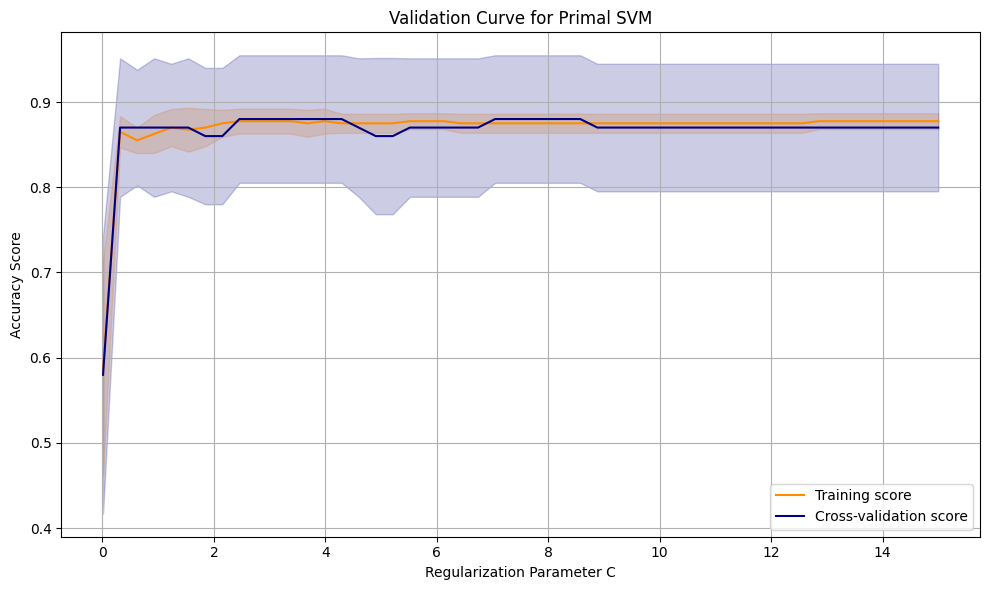

In [7]:
# Calculate mean and standard deviation of scores across folds
train_avg = np.mean(training_scores, axis=1)
train_std = np.std(training_scores, axis=1)
valid_avg = np.mean(validation_scores, axis=1)
valid_std = np.std(validation_scores, axis=1)

# Plot the validation curve to visualize performance vs. C
plt.figure(figsize=(10, 6))
plt.title("Validation Curve for Primal SVM")
plt.xlabel("Regularization Parameter C")
plt.ylabel("Accuracy Score")

# Plot training score with a confidence band (mean +/- std dev)
plt.plot(c_values, train_avg, label="Training score", color="darkorange")
plt.fill_between(c_values, train_avg - train_std, train_avg + train_std,
                 alpha=0.2, color="darkorange")

# Plot validation score with a confidence band
plt.plot(c_values, valid_avg, label="Cross-validation score", color="navy")
plt.fill_between(c_values, valid_avg - valid_std, valid_avg + valid_std,
                 alpha=0.2, color="navy")

plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.2 Final Model Training and Visualization (Primal SVM)

In [8]:
# Select the C that gives the highest average validation score
best_index = np.argmax(valid_avg)
best_C = c_values[best_index]
best_val_score = valid_avg[best_index]

print(f"Optimal value of C based on cross-validation: {best_C:.4f}")
print(f"Best cross-validation score: {best_val_score:.4f}\n")

# Retrain the model on the full dataset using the optimal C
w_opt, b_opt, xi_opt = train_svm_primal(X, y, best_C)

# Evaluate performance on the entire training set
y_pred = predict(X, w_opt, b_opt)
conf_matrix = confusion_matrix(y, y_pred)
accuracy = np.mean(y_pred == y) * 100

print("Confusion Matrix (Full Training Set):")
print(conf_matrix)
print(f"\nAccuracy on full training set: {accuracy:.2f}%")

Optimal value of C based on cross-validation: 2.4573
Best cross-validation score: 0.8800

Confusion Matrix (Full Training Set):
[[46  6]
 [ 7 41]]

Accuracy on full training set: 87.00%


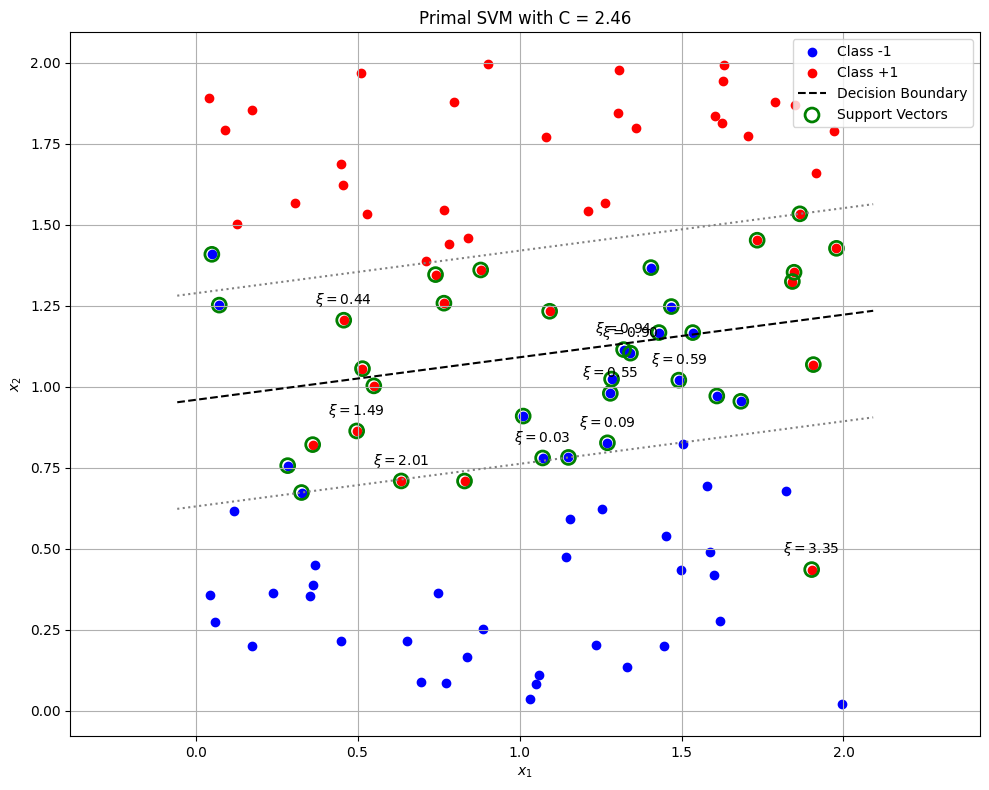

In [9]:
# Function to plot the decision boundary and support vectors
def plot_svm_boundary(X, y, w, b, xi):
    """Visualizes the SVM decision boundary, margins, and support vectors."""
    
    plt.figure(figsize=(10, 8))
    
    # Plot data points by class
    plt.scatter(X[(y == -1).flatten(), 0], X[(y == -1).flatten(), 1], color='blue', label='Class -1')
    plt.scatter(X[(y == 1).flatten(), 0], X[(y == 1).flatten(), 1], color='red', label='Class +1')

    # Get current plot limits to define line range
    ax = plt.gca()
    xlim = ax.get_xlim()

    # Define the separating hyperplane
    # w0*x0 + w1*x1 + b = 0  =>  x1 = (-w0*x0 - b) / w1
    x_vals = np.array(xlim)
    y_vals = -(w[0] * x_vals + b) / w[1]
    plt.plot(x_vals, y_vals, '--', color='black', label='Decision Boundary')
    
    # Plot the margins (w'x + b = 1 and w'x + b = -1)
    margin_plus_y = -(w[0] * x_vals + b - 1) / w[1]
    margin_minus_y = -(w[0] * x_vals + b + 1) / w[1]
    plt.plot(x_vals, margin_plus_y, ':', color='gray')
    plt.plot(x_vals, margin_minus_y, ':', color='gray')

    # Identify and highlight support vectors
    # These are points where the functional margin is <= 1
    y_pred_margin = X @ w + b # Use raw output before sign()
    functional_margin = y.flatten() * y_pred_margin.flatten()
    sv_mask = (functional_margin <= 1.001) # Use small tolerance
    support_vectors = X[sv_mask]
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                s=100, facecolors='none', edgecolors='green',
                linewidths=2, label='Support Vectors')
    
    # Annotate a few support vectors with their slack values (xi)
    slacks = xi[sv_mask]
    # Display slack values only for vectors with significant slack
    slack_sv_indices = np.where(slacks > 1e-4)[0]
    for i in slack_sv_indices[:10]: # Annotate up to 10
        sv_point = support_vectors[i]
        slack_val = slacks[i]
        plt.text(sv_point[0], sv_point[1] + 0.05, f'$\\xi={slack_val.item():.2f}$', ha='center')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(f'Primal SVM with C = {best_C:.2f}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.axis('equal')
    plt.show()

# Plot the final result
plot_svm_boundary(X, y, w_opt, b_opt, xi_opt)

Validation of the solution using sklearn built-in functions

In [10]:
# Train an SVM with C I obtained
linear_svm = SVC(kernel='linear', C=best_C)
linear_svm.fit(X, y.flatten())
y_pred_linear = linear_svm.predict(X)
accuracy_linear = accuracy_score(y.flatten(), y_pred_linear) * 100
conf_matrix_linear = confusion_matrix(y.flatten(), y_pred_linear)

print(f"Accuracy of sklearn SVM with my C({best_C:.4f}): {accuracy_linear:.2f}%")
print("Confusion Matrix:")
print(conf_matrix_linear)
print("--- Comparison ---")
print(f"Custom Primal SVM: Accuracy={accuracy:.2f}%")
print(f"Sklearn Linear SVM: Accuracy={accuracy_linear:.2f}%")


# Define the parameter grid for C
param_grid = {'C': np.logspace(-3, 3, 50)}  # Search over a wide range of C values
svm = SVC(kernel='linear')

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y.flatten())

# Extract the best C value and the corresponding model
best_C_gridsearch = grid_search.best_params_['C']
best_model_gridsearch = grid_search.best_estimator_

# Predict on the training set using the best model
y_pred_gridsearch = best_model_gridsearch.predict(X)

# Evaluate the model
accuracy_gridsearch = accuracy_score(y.flatten(), y_pred_gridsearch) * 100
conf_matrix_gridsearch = confusion_matrix(y.flatten(), y_pred_gridsearch)

print(f"\nOptimal value of C from GridSearchCV: {best_C_gridsearch:.4f}")
print(f"Accuracy of sklearn SVM with optimal C: {accuracy_gridsearch:.2f}%")
print("Confusion Matrix:")
print(conf_matrix_gridsearch)

Accuracy of sklearn SVM with my C(2.4573): 87.00%
Confusion Matrix:
[[46  6]
 [ 7 41]]
--- Comparison ---
Custom Primal SVM: Accuracy=87.00%
Sklearn Linear SVM: Accuracy=87.00%

Optimal value of C from GridSearchCV: 1.5264
Accuracy of sklearn SVM with optimal C: 87.00%
Confusion Matrix:
[[46  6]
 [ 7 41]]


## Part 2: Dual SVM with Non-linear (RBF) Kernel

We now solve the dual optimization problem with a Gaussian (RBF) kernel:
$$ \max_{\alpha} \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha_i \alpha_j y^{(i)} y^{(j)} K(x^{(i)}, x^{(j)}) $$
subject to:
$$ \sum_{i=1}^{m} \alpha_i y^{(i)} = 0, \quad 0 \le \alpha_i \le C, \quad i=1, \dots, m $$
where the Gaussian kernel is $ K(x, z) = \exp\left(-\frac{\|x - z\|^2}{2\sigma^2}\right) $.

In [11]:
def gaussian_kernel(x, z, sigma):
    """Computes the Gaussian (RBF) kernel between two sets of vectors."""
    n, m = x.shape[0], z.shape[0]
    # Use the squared Euclidean distance: ||x-z||^2 = ||x||^2 + ||z||^2 - 2x'z
    xx = np.dot(np.sum(np.power(x, 2), 1).reshape(n, 1), np.ones((1, m)))
    zz = np.dot(np.sum(np.power(z, 2), 1).reshape(m, 1), np.ones((1, n)))
    return np.exp(-(xx + zz.T - 2 * np.dot(x, z.T)) / (2 * sigma ** 2))

In [12]:
def train_svm_dual(X_train, y_train, C, sigma):
    """
    Trains a non-linear SVM using the dual formulation with a Gaussian kernel.

    Args:
        X_train (np.ndarray): Training features, shape (m, n).
        y_train (np.ndarray): Training labels, shape (m, 1), values in {-1, 1}.
        C (float): Regularization parameter.
        sigma (float): Bandwidth parameter for the Gaussian kernel.
        
    Returns:
        alphas (np.ndarray): The learned alpha coefficients, shape (m, 1).
        b (float): The learned bias term.
        support_vectors (dict): Dictionary containing SV features, labels, and alphas.
    """
    m, n = X_train.shape

    # 1. Compute the Gram matrix using the Gaussian kernel
    K = gaussian_kernel(X_train, X_train, sigma)

    # 2. Define the QP problem for the dual. cvxopt minimizes, so we minimize -W(alpha).
    # min (1/2) * alpha' * P * alpha + q' * alpha
    P = (y_train @ y_train.T) * K
    q = -np.ones((m, 1))

    # 3. Equality constraint: y' * alpha = 0
    A = y_train.T
    b_eq = np.zeros(1)

    # 4. Inequality constraints: 0 <= alpha_i <= C
    # -alpha_i <= 0 and alpha_i <= C
    G = np.vstack((-np.eye(m), np.eye(m)))
    h = np.hstack((np.zeros(m), np.ones(m) * C))

    # Convert to cvxopt matrices
    P_cvx, q_cvx = matrix(P), matrix(q)
    A_cvx, b_cvx = matrix(A), matrix(b_eq)
    G_cvx, h_cvx = matrix(G), matrix(h)

    # Solve QP problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P_cvx, q_cvx, G_cvx, h_cvx, A_cvx, b_cvx)
    alphas = np.array(solution['x'])

    # 5. Compute the bias term b
    # Find support vectors on the margin (0 < alpha < C)
    margin_sv_mask = ((alphas > 1e-4) & (alphas < C * 0.999)).flatten()
    
    if np.any(margin_sv_mask):
        b_vals = y_train[margin_sv_mask] - (alphas * y_train).T @ K[:, margin_sv_mask]
        b = np.mean(b_vals)
    else:
        # Fallback if no SVs are on the margin (can happen with some C values)
        # This is a less stable way to calculate b, but necessary as a fallback
        print("Warning: No support vectors on the margin found. Bias may be unstable.")
        b = 0 # Or a more sophisticated fallback
    
    # 6. Store all support vectors (alpha > 0) for prediction
    sv_mask = (alphas > 1e-5).flatten()
    support_vectors = {
        'X': X_train[sv_mask],
        'y': y_train[sv_mask],
        'alpha': alphas[sv_mask]
    }

    return alphas, b, support_vectors

In [13]:
def predict_dual(X_predict, b, sv_dict, sigma):
    """Predicts labels using the dual SVM model."""
    if sv_dict['X'].shape[0] == 0:
        return np.ones((X_predict.shape[0], 1)) * np.sign(b)
    
    x_sv, y_sv, alphas_sv = sv_dict['X'], sv_dict['y'], sv_dict['alpha']
    kernel_output = gaussian_kernel(X_predict, x_sv, sigma)
    
    # Note the transpose on the kernel output compared to the training calculation
    y_pred_vals = kernel_output @ (alphas_sv * y_sv) + b
    return np.sign(y_pred_vals).reshape((X_predict.shape[0], 1))

### 2.1 Hyperparameter Tuning for C (Dual SVM) using 5-Fold Cross-Validation

We will fix `sigma` to a reasonable value (e.g., 0.27) that was obtainded by experimental testing and perform cross-validation to find the best `C`.

In [14]:
# Define hyperparameter ranges
c_values = np.linspace(0.01, 20, 50)
# sigma = 0.27 # Kernel bandwidth, fixed for this tuning run
sigma = 0.5896

# Initialize score matrices
training_scores_dual = np.zeros((len(c_values), 5))
validation_scores_dual = np.zeros((len(c_values), 5))

num_folds = 5
n_samples = X.shape[0]
fold_size = n_samples // num_folds

# 5-fold cross-validation loop
for idx, C in enumerate(c_values):
    for fold in range(num_folds):
        # Create train/validation splits
        start, end = fold * fold_size, (fold + 1) * fold_size
        x_valid, y_valid = X[start:end], y[start:end]
        x_train = np.concatenate((X[:start], X[end:]), axis=0)
        y_train = np.concatenate((y[:start], y[end:]), axis=0)

        # Train model using dual formulation
        _, b, sv_dict = train_svm_dual(x_train, y_train, C, sigma)

        # Predict and evaluate
        y_pred_train = predict_dual(x_train, b, sv_dict, sigma)
        y_pred_valid = predict_dual(x_valid, b, sv_dict, sigma)

        # Store results
        training_scores_dual[idx, fold] = np.mean(y_pred_train == y_train)
        validation_scores_dual[idx, fold] = np.mean(y_pred_valid == y_valid)

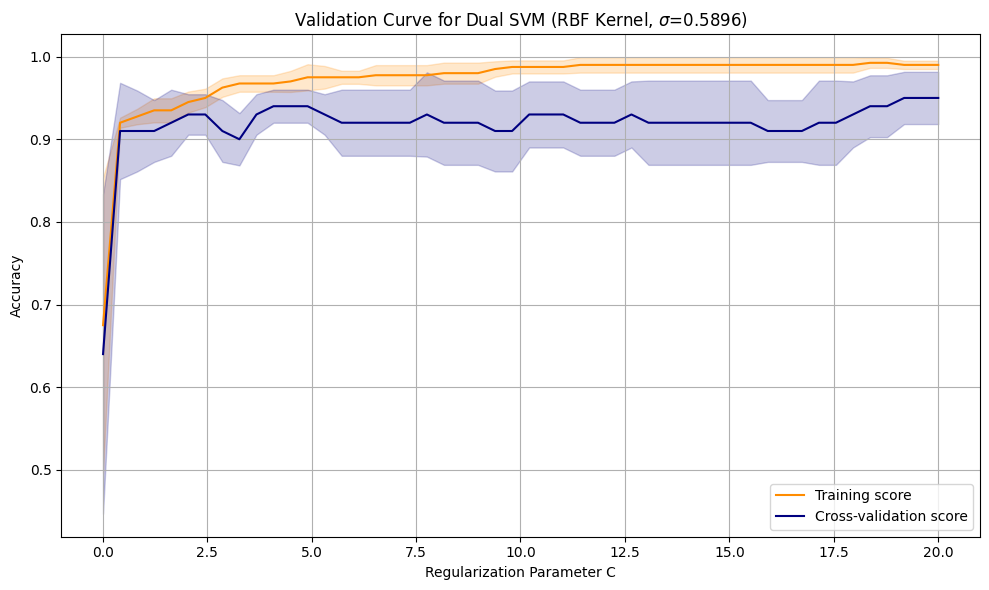

In [15]:
# Calculate mean and standard deviation of scores
train_avg_dual = np.mean(training_scores_dual, axis=1)
train_std_dual = np.std(training_scores_dual, axis=1)
valid_avg_dual = np.mean(validation_scores_dual, axis=1)
valid_std_dual = np.std(validation_scores_dual, axis=1)

# Plot the validation curve for the dual SVM
plt.figure(figsize=(10, 6))
plt.title(f"Validation Curve for Dual SVM (RBF Kernel, $\sigma$={sigma})")
plt.xlabel("Regularization Parameter C")
plt.ylabel("Accuracy")

plt.plot(c_values, train_avg_dual, label="Training score", color="darkorange")
plt.fill_between(c_values, train_avg_dual - train_std_dual, train_avg_dual + train_std_dual,
                 alpha=0.2, color="darkorange")

plt.plot(c_values, valid_avg_dual, label="Cross-validation score", color="navy")
plt.fill_between(c_values, valid_avg_dual - valid_std_dual, valid_avg_dual + valid_std_dual,
                 alpha=0.2, color="navy")

plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.2 Final Model Training and Visualization (Dual SVM)

In [16]:
# Find the optimal C from the cross-validation results
best_index_dual = np.argmax(valid_avg_dual)
best_C_dual = c_values[best_index_dual]
best_val_score_dual = valid_avg_dual[best_index_dual]

print(f"Optimal value of C: {best_C_dual:.4f}")
print(f"Best cross-validation score: {best_val_score_dual:.4f}\n")

# Retrain the model on the entire dataset with the best C and sigma
final_alphas, final_b, final_sv_dict = train_svm_dual(X, y, best_C_dual, sigma)

# Evaluate performance on the training set
y_pred_final = predict_dual(X, final_b, final_sv_dict, sigma)
conf_matrix_dual = confusion_matrix(y, y_pred_final)
accuracy_dual = np.mean(y_pred_final == y) * 100

print("Confusion Matrix (Full Training Set):")
print(conf_matrix_dual)
print(f"\nTraining accuracy: {accuracy_dual:.2f}%")

Optimal value of C: 19.1841
Best cross-validation score: 0.9500

Confusion Matrix (Full Training Set):
[[51  1]
 [ 1 47]]

Training accuracy: 98.00%


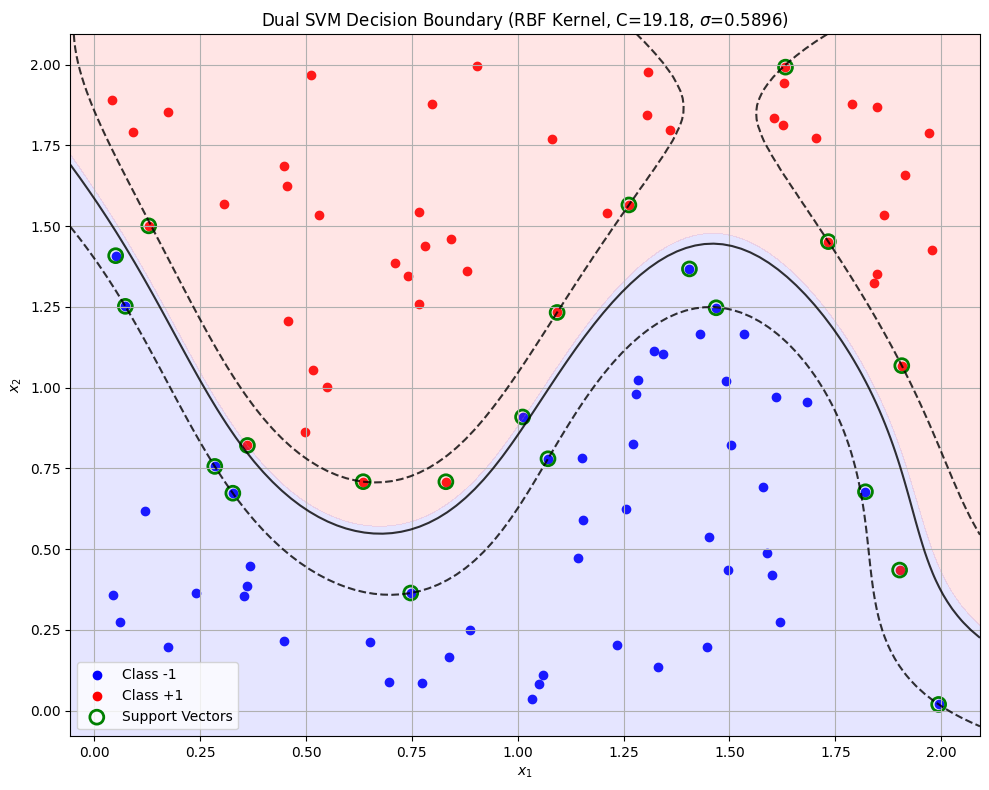

In [17]:
def plot_svm_decision_region(X, y, b, sv_dict, sigma):
    """Visualizes the non-linear decision boundary for the dual SVM."""
    
    x_sv = sv_dict['X']
    
    plt.figure(figsize=(10, 8))
    
    # Plot data points
    plt.scatter(X[(y == -1).flatten(), 0], X[(y == -1).flatten(), 1], color='blue', label='Class -1')
    plt.scatter(X[(y == 1).flatten(), 0], X[(y == 1).flatten(), 1], color='red', label='Class +1')
    
    # Create a meshgrid to plot the decision boundary
    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), 
                         np.linspace(ylim[0], ylim[1], 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Calculate the decision function value for each grid point
    # Use the predict function logic but without the final sign()
    if x_sv.shape[0] > 0:
        y_sv, alphas_sv = sv_dict['y'], sv_dict['alpha']
        kernel_vals = gaussian_kernel(grid_points, x_sv, sigma)
        decision_values = kernel_vals @ (alphas_sv * y_sv) + b
    else:
        decision_values = np.ones(grid_points.shape[0]) * b
        
    Z = decision_values.reshape(xx.shape)

    # Plot decision boundary (Z=0) and margins (Z=-1, 1)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, linestyles=['--', '-', '--'])
    # Fill the regions with color
    plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.2, levels=np.linspace(Z.min(), Z.max(), 3))

    # Highlight support vectors
    if x_sv.shape[0] > 0:
        plt.scatter(x_sv[:, 0], x_sv[:, 1], s=100, facecolors='none', 
                    edgecolors='green', linewidths=2, label='Support Vectors')

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(f'Dual SVM Decision Boundary (RBF Kernel, C={best_C_dual:.2f}, $\sigma$={sigma})')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the final result for the dual SVM
plot_svm_decision_region(X, y, final_b, final_sv_dict, sigma)

Validation of the solution using sklear built in functions

My implementation used sigma = 0.5896, which is equivalent to gamma ≈ 1.4383 in scikit-learn.

Fitting 5 folds for each of 400 candidates, totalling 2000 fits

--- Scikit-learn GridSearchCV Results ---
Optimal value of C found by GridSearchCV: 4.2813
Optimal value of gamma found by GridSearchCV: 1.4384
(This corresponds to sigma ≈ 0.5896)



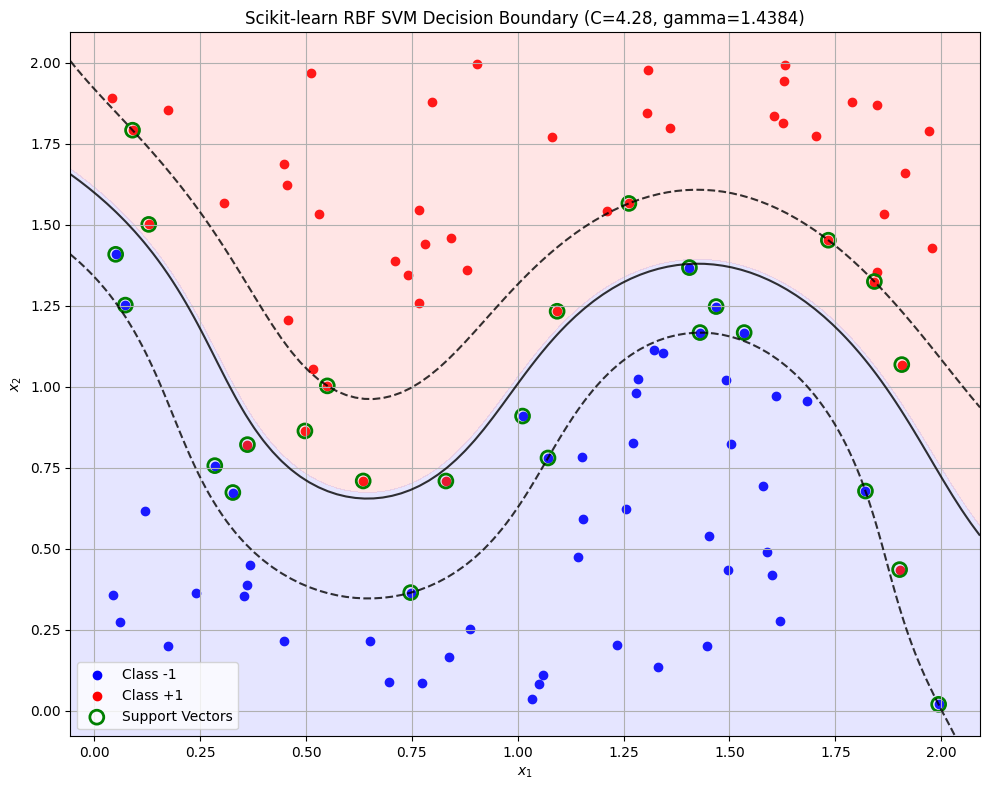

In [18]:
# A full grid search using scikit-learn.
# Scikit-learn's gamma - gamma = 1 / (2 * sigma^2).
custom_sigma = sigma
equivalent_gamma = 1 / (2 * custom_sigma**2)
print(f"My implementation used sigma = {custom_sigma}, which is equivalent to gamma ≈ {equivalent_gamma:.4f} in scikit-learn.\n")

# Define the parameter grid for C and gamma for the grid search.
param_grid_rbf = {
    'C': np.logspace(0, 2, 20),      # Search from 1 to 100
    'gamma': np.logspace(-1, 1, 20) # Search for gamma around the equivalent value
}

# Create an SVM classifier with an RBF kernel
svm_rbf = SVC(kernel='rbf')

# Perform grid search with 5-fold cross-validation
grid_search_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid_rbf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rbf.fit(X, y.flatten())

# Extract the best parameters and the best model
best_params_sklearn = grid_search_rbf.best_params_
best_C_sklearn = best_params_sklearn['C']
best_gamma_sklearn = best_params_sklearn['gamma']
best_model_sklearn = grid_search_rbf.best_estimator_

print("\n--- Scikit-learn GridSearchCV Results ---")
print(f"Optimal value of C found by GridSearchCV: {best_C_sklearn:.4f}")
print(f"Optimal value of gamma found by GridSearchCV: {best_gamma_sklearn:.4f}")
sigma_sklearn = np.sqrt(1 / (2 * best_gamma_sklearn))
print(f"(This corresponds to sigma ≈ {sigma_sklearn:.4f})\n")

# Predict on the entire training set using the best model from the grid search
y_pred_sklearn = best_model_sklearn.predict(X)

# Plot the decision boundary for the best model found by GridSearchCV
def plot_sklearn_rbf_decision_boundary(X, y, model, title):
    """Plots the decision boundary for an RBF SVM model trained with scikit-learn."""
    plt.figure(figsize=(10, 8))
    
    # Plot data points
    plt.scatter(X[(y.flatten() == -1), 0], X[(y.flatten() == -1), 1], color='blue', label='Class -1')
    plt.scatter(X[(y.flatten() == 1), 0], X[(y.flatten() == 1), 1], color='red', label='Class +1')
    
    # Create a meshgrid to plot the decision boundary
    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), 
                         np.linspace(ylim[0], ylim[1], 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict decision function values for the grid points
    Z = model.decision_function(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary (Z=0) and margins (Z=-1, 1)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, linestyles=['--', '-', '--'])
    # Fill the regions with color
    plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.2, levels=np.linspace(Z.min(), Z.max(), 3))
    
    # Highlight support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], 
                s=100, facecolors='none', edgecolors='green', linewidths=2, label='Support Vectors')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the decision boundary for the scikit-learn RBF SVM
plot_sklearn_rbf_decision_boundary(X, y, best_model_sklearn, 
                                   f"Scikit-learn RBF SVM Decision Boundary (C={best_C_sklearn:.2f}, gamma={best_gamma_sklearn:.4f})")

The results are highly comparable, confirming the correctness of the custom dual implementation.
Scikit-learn’s extensive grid search over both C and gamma can sometimes identify slightly better hyperparameter combinations.
(Further improvement may be possible by expanding the gamma search in my case more thoroughly.)